In [1]:
import torch
def get_gaussian_maps(mu, shape_hw, inv_std, mode='rot'):
  """
  Generates [B,SHAPE_H,SHAPE_W,NMAPS] tensor of 2D gaussians,
  given the gaussian centers: MU [B, NMAPS, 2] tensor.
  STD: is the fixed standard dev.
  """

  mu_y, mu_x = mu[:, :, 0:1], mu[:, :, 1:2]

  #y = tf.to_float(tf.linspace(-1.0, 1.0, shape_hw[0]))
  y = torch.linspace(-1.0, 1.0, shape_hw[0])
  x = torch.linspace(-1.0, 1.0, shape_hw[1])
  
  
  if mode in ['rot', 'flat']:
    #mu_y, mu_x = tf.expand_dims(mu_y, -1), tf.expand_dims(mu_x, -1)
    mu_y, mu_x = mu_y.unsqueeze(-1), mu_x.unsqueeze(-1)
    y = torch.reshape(y, [1, 1, shape_hw[0], 1])
    x = torch.reshape(x, [1, 1, 1, shape_hw[1]])

    g_y = torch.square(y - mu_y)
    g_x = torch.square(x - mu_x)
    dist = (g_y + g_x) * inv_std**2

    if mode == 'rot':
      g_yx = torch.exp(-dist)
    else:
      g_yx = torch.exp(-torch.pow(dist + 1e-5, 0.25))
  
  elif mode == 'ankush':
    #y = tf.reshape(y, [1, 1, shape_hw[0]])
    y = y.reshape(1, 1, shape_hw[0])
    x = x.reshape(1, 1, shape_hw[1])

    g_y = torch.exp(-torch.sqrt(1e-4 + torch.abs((mu_y - y) * inv_std)))
    g_x = torch.exp(-torch.sqrt(1e-4 + torch.abs((mu_x - x) * inv_std)))

    #g_y = torch.expand_dims(g_y, axis=3)
    g_y = g_y.unsqueeze(3)
    #g_x = torch.expand_dims(g_x, axis=2)
    g_x = g_x.unsqueeze(2)
    g_yx = torch.matmul(g_y, g_x)  # [B, NMAPS, H, W]

  else:
    raise ValueError('Unknown mode: ' + str(mode))

  g_yx = g_yx.permute((0, 2, 3, 1))
  return g_yx

In [23]:
def denorm(x):
    return (x / 2 + 0.5).clamp(0, 1)

In [54]:
from training.mobile_face_net import load_face_landmark_detector


landmark_detector = load_face_landmark_detector()
landmark_detector = landmark_detector.to('cpu')
landmark_detector.eval()
import imageio as io

img = torch.tensor(io.imread('/home/nas4_user/jaeseonglee/ICCV2023/eg3d/eg3d/inthewild_data/candal.png'),dtype=torch.float32).permute((2,0,1)).unsqueeze(0)
ldmks,M,m = landmark_detector.get_face_landmark(img/255)

tensor(0.8734)


In [55]:
ldmks.max(),ldmks.min(),img.max(),img.min()

(tensor(447.1656), tensor(92.5041), tensor(255.), tensor(0.))

In [ ]:
def draw_image_landmarks(image, points):
    """ draw landmarks over the image and return the figure
    
    :param image: np.array<height, width, 3>
    :param points: np.array<nb_points, 2>
    :return: object
    """
    import numpy as np
    shape = np.array(image.shape[:2])
    fig_size = shape / float(max(shape)) * FIG_MAX_SIZE
    fig_size = np.array(fig_size).tolist()[-1::-1]
    fig = plt.figure(figsize=fig_size)
    ax = fig.gca()
    ax.imshow(image)
    ax.plot(points[:, 1], points[:, 0], 'o', color='k')
    ax.plot(points[:, 1], points[:, 0], '.', color='w')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_xlim(0, shape[1])
    ax.set_ylim(shape[0], 0)
    fig.tight_layout()
    return fig 

In [56]:
heatmap = get_gaussian_maps(ldmks/512,  [112,112], 1/.1)

In [57]:
heatmap= heatmap[0]

In [66]:

heatmap[...,5].max(),heatmap.shape

(tensor(0.9928), torch.Size([112, 112, 68]))

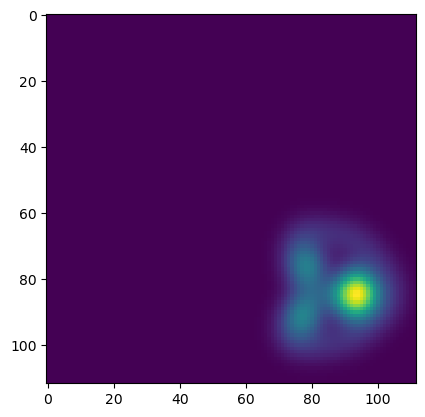

In [60]:
import matplotlib.pyplot as plt

#plt.imshow(heatmap[...,].sum(-1)*112)

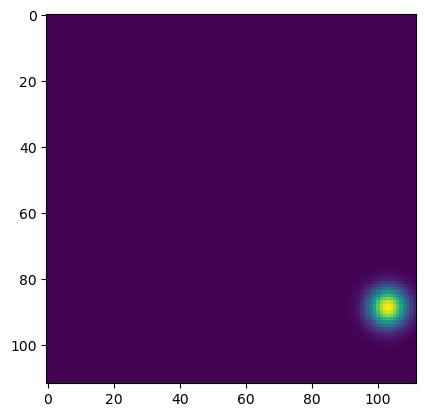

In [76]:
plt.imshow(heatmap[...,9])